In [7]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

In [8]:
books = pd.read_csv('input/transformed/books.csv', usecols=['book_idx', 'title_idx', 'author_idx', 'publisher_idx'])
users = pd.read_csv('input/transformed/users.csv', usecols=['user_idx', 'age', 'city_idx', 'province_idx', 'country_idx'])
train_ratings = pd.read_csv('input/transformed/train_ratings.csv', usecols=['id', 'user_idx', 'book_idx', 'rating'])
test_ratings = pd.read_csv('input/transformed/test_ratings.csv', usecols=['id', 'user_idx', 'book_idx'])

In [9]:
train = train_ratings.merge(users, on=['user_idx']).merge(books, on=['book_idx']).sort_values(by='id').drop('id', axis=1)
train['rating'] -= 1

In [10]:
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
X, y = train.drop('rating', axis=1), train['rating']

validations = []

for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    lgb_params = {
        'objective': 'multiclass',
        'num_class': 10,
        'verbose': -1,
        'learning_rate': 0.01,
        'num_leaves': 63,
    }
    model = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval, num_boost_round=2000, callbacks=[lgb.early_stopping(20)])

    y_pred = model.predict(X_test)
    y_pred_idx = y_pred.argmax(axis=1)
    score = f1_score(y_test, y_pred_idx, average='micro')
    print(score)

    validations.append(pd.concat([
        pd.DataFrame({
            'rating': y_test.values,
        }),
        pd.DataFrame(y_pred, columns=[f'class{i}' for i in range(10)])
    ], axis=1))
pd.concat(validations).to_csv("output/lgbm_valid.csv", index=False)


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1758]	valid_0's multi_logloss: 1.77786
0.31349979553053814
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1852]	valid_0's multi_logloss: 1.77368
0.31603762238098676
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's multi_logloss: 1.77587
0.31591734622693707


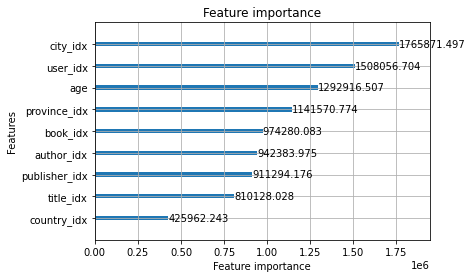

In [11]:
test_ratings = pd.read_csv('input/transformed/test_ratings.csv', usecols=['id', 'user_idx', 'book_idx'])
test = test_ratings.merge(users, on=['user_idx']).merge(books, on=['book_idx'])
X_test = test.drop('id', axis=1)

lgb_train = lgb.Dataset(X, y)
model = lgb.train(lgb_params, lgb_train, num_boost_round=model.best_iteration)

lgb.plot_importance(model, importance_type='gain')

y_pred = model.predict(X_test)
y_pred_idx = y_pred.argmax(axis=1)

pred = pd.concat([test[['id']], pd.DataFrame(y_pred, columns=[f'class{i}' for i in range(10)])], axis=1)
pred['rating'] = y_pred_idx + 1

In [12]:
assert pred['rating'].min() == 1 and pred['rating'].max() == 10
pred.to_csv('output/lgbm.csv', index=False)
pred[['id', 'rating']].to_csv('output/lgbm_submission.csv', index=False)